# Attentional pooling - exploratory notebook

8/11/25 \
See related slides [[here]](https://docs.google.com/presentation/d/1cyBwBMWjbY69hn11i7VACnMMv64p8GOk_EKJvEaFqT0/edit?slide=id.p#slide=id.p)

In [1]:
import os
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

from epsclassifiers.intern_vit_classifier.intern_vit_classifier import (
    InternVitClassifier,
)

# With CLS concat.
# ATTENTIONAL_POOLING_CONCAT_CLS = True
# CLASSIFIER_PT_CHECKPOINT_PATH = "/home/arjun/spine_fracture_output/output_attnpool_clsconcat_lr1e-4/output_attnpool_lr3e-4_clsconcat/cls_nonchest-training-on-combined_spine_fracture/checkpoint/checkpoint_epoch_10_20250811_002856_utc.pt"

# No CLS concat.
CLASSIFIER_PT_CHECKPOINT_PATH = "/home/arjun/spine_fracture_output/output_attnpool_lr3e-4/cls_nonchest-training-on-combined_spine_fracture/checkpoint/checkpoint_epoch_10_20250810_115945_utc.pt"

# Try different input images.
IMAGE_FPS = [
    "/mnt/data/png/512x512/gradient/16AUG2024/GRDN9H2DBDTWN7CB/GRDNVCWJGK2WM6TX/studies/1.2.826.0.1.3680043.8.498.18104757842059133543173075329559209720/series/1.2.826.0.1.3680043.8.498.64165948856047495885430798969381147837/instances/1.2.826.0.1.3680043.8.498.27058670524842555748126319683463106315.png",
    "/mnt/data/png/512x512/gradient/16AUG2024/GRDNEBO9K2OI9OZX/GRDN4EPLSU80SSUO/studies/1.2.826.0.1.3680043.8.498.65592547228413770243926093991651480310/series/1.2.826.0.1.3680043.8.498.34013325821401913095414710019583920540/instances/1.2.826.0.1.3680043.8.498.23658638165085891119612239951308897610.png",
    "/mnt/data/png/512x512/segmed/batch1/494493/494493-XRAY_BATCH_1_174-1/1.3.6.1.4.1.55648.313042589361399449368691875404851112815/1.3.6.1.4.1.55648.313042589361399449368691875404851112815.1/1.3.6.1.4.1.55648.313042589361399449368691875404851112815.1.2.green.png",
    "/mnt/data/png/512x512/segmed/batch1/494493/494493-XRAY_BATCH_1_174-1/1.3.6.1.4.1.55648.313042589361399449368691875404851112815/1.3.6.1.4.1.55648.313042589361399449368691875404851112815.1/1.3.6.1.4.1.55648.313042589361399449368691875404851112815.1.3.green.png",
    "/mnt/data/png/512x512/gradient/13JAN2025/deid/GRDNXA8E3FOAHXOR/GRDNDAGUSDJVDN9I/studies/1.2.826.0.1.3680043.8.498.57623790477802983897813953137859356689/series/1.2.826.0.1.3680043.8.498.83837729261919706945677869473664677621/instances/1.2.826.0.1.3680043.8.498.34991133961453118089953983811826784201.png",
    "/mnt/data/png/512x512/gradient/13JAN2025/deid/GRDNXA8E3FOAHXOR/GRDNDAGUSDJVDN9I/studies/1.2.826.0.1.3680043.8.498.57623790477802983897813953137859356689/series/1.2.826.0.1.3680043.8.498.83837729261919706945677869473664677621/instances/1.2.826.0.1.3680043.8.498.94945600088708127397592422765872850987.png",
    "/mnt/data/png/512x512/gradient/13JAN2025/deid/GRDNXA8E3FOAHXOR/GRDNDAGUSDJVDN9I/studies/1.2.826.0.1.3680043.8.498.57623790477802983897813953137859356689/series/1.2.826.0.1.3680043.8.498.83837729261919706945677869473664677621/instances/1.2.826.0.1.3680043.8.498.46675379463517454693595676143685192563.png",
    "/mnt/data/png/512x512/gradient/13JAN2025/deid/GRDNXA8E3FOAHXOR/GRDNDAGUSDJVDN9I/studies/1.2.826.0.1.3680043.8.498.57623790477802983897813953137859356689/series/1.2.826.0.1.3680043.8.498.83837729261919706945677869473664677621/instances/1.2.826.0.1.3680043.8.498.34504123601325466534377307747784987660.png",
    "/mnt/data/png/512x512/gradient/13JAN2025/deid/GRDNXA8E3FOAHXOR/GRDNDAGUSDJVDN9I/studies/1.2.826.0.1.3680043.8.498.57623790477802983897813953137859356689/series/1.2.826.0.1.3680043.8.498.83837729261919706945677869473664677621/instances/1.2.826.0.1.3680043.8.498.23520487737157804412623410355202000373.png",
]
REPORTS = [
    """CLINICAL DATA:
Motor vehicle accident. Chest pain.
EXAM:
STERNUM 2+ VIEW
COMPARISON:
One previous study.
FINDINGS:
Fracture of the lower body of the sternum. Upper portion of the sternum is depressed [X] cm relative to the lower portion.
IMPRESSION:
1. Fracture of the lower body of the sternum.
2. Depression of the upper portion of the sternum by [X] cm relative to the lower portion.""",
    """CLINICAL DATA:
Pain post fall off ladder.
EXAM:
LUMBAR SPINE COMPLETE 4+ VIEW
COMPARISON:
None found.
FINDINGS:
Subtle cortical irregularity at the anterior aspect of the T12 vertebral body with mild loss of height anteriorly, suggesting mild compression deformity of indeterminate age. Cortical irregularity along the anterior margin of the L1 vertebral body with linear sclerosis across the body below the superior endplate, suggesting mild compression deformity of indeterminate age. No bony retropulsion. No posterior element involvement. Alignment is preserved. Disc heights are maintained throughout.
IMPRESSION:
1. Mild T12 compression deformity, age indeterminate.
2. Mild L1 compression deformity, age indeterminate""",
    """CLINICAL DATA:
Thoracic pain.
EXAM:
THORACIC SPINE XRAY AP AND LATERAL
COMPARISON:
None found.
FINDINGS:
Compression fracture deformity of T8 with loss of height of the anterior aspect of the vertebral body. No retropulsion of the fracture fragment. Remaining thoracic vertebral bodies are normal height. Osteophytic ridging along vertebral body margins. No destructive abnormalities or additional fracture. Posterior elements and pedicles are intact. No displacement of paraspinal lines.
IMPRESSION:
1. Compression fracture deformity of T8.
2. Mild degenerative changes.""",
    """CLINICAL DATA:
Thoracic pain.
EXAM:
THORACIC SPINE XRAY AP AND LATERAL
COMPARISON:
None found.
FINDINGS:
Compression fracture deformity of T8 with loss of height of the anterior aspect of the vertebral body. No retropulsion of the fracture fragment. Remaining thoracic vertebral bodies are normal height. Osteophytic ridging along vertebral body margins. No destructive abnormalities or additional fracture. Posterior elements and pedicles are intact. No displacement of paraspinal lines.
IMPRESSION:
1. Compression fracture deformity of T8.
2. Mild degenerative changes.""",
"""CLINICAL DATA:
Lumbosacral back pain. Fall yesterday. Right flank and right back pain radiating down right leg. Patient reports pain prior to fall.
EXAM:
LUMBAR SPINE COMPLETE 4+ VIEW
COMPARISON:
None found.
FINDINGS:
Diminutive ribs at T12. Moderately severe T12 compression fracture with approximately [X]% loss of height anteriorly. Mild compression fracture at T11 and possibly T10. Chronic loss of height of L1 vertebral body. Modic endplate changes with endplate sclerosis at L1-L2 and L2-L3. Diffuse disc disease with disc space narrowing, endplate spurring, and vacuum phenomenon, most prominent at L1-L2. Multilevel facet hypertrophy.
IMPRESSION:
1. Moderately severe T12 compression fracture with approximately [X]% loss of height anteriorly.
2. Mild T11 and possibly T10 compression fractures.
3. Chronic mild loss of height of L1.
4. Multilevel degenerative disc disease and facet hypertrophy, most prominent at L1-L2 and L2-L3.""",
"""CLINICAL DATA:
Lumbosacral back pain. Fall yesterday. Right flank and right back pain radiating down right leg. Patient reports pain prior to fall.
EXAM:
LUMBAR SPINE COMPLETE 4+ VIEW
COMPARISON:
None found.
FINDINGS:
Diminutive ribs at T12. Moderately severe T12 compression fracture with approximately [X]% loss of height anteriorly. Mild compression fracture at T11 and possibly T10. Chronic loss of height of L1 vertebral body. Modic endplate changes with endplate sclerosis at L1-L2 and L2-L3. Diffuse disc disease with disc space narrowing, endplate spurring, and vacuum phenomenon, most prominent at L1-L2. Multilevel facet hypertrophy.
IMPRESSION:
1. Moderately severe T12 compression fracture with approximately [X]% loss of height anteriorly.
2. Mild T11 and possibly T10 compression fractures.
3. Chronic mild loss of height of L1.
4. Multilevel degenerative disc disease and facet hypertrophy, most prominent at L1-L2 and L2-L3.""",
"""CLINICAL DATA:
Lumbosacral back pain. Fall yesterday. Right flank and right back pain radiating down right leg. Patient reports pain prior to fall.
EXAM:
LUMBAR SPINE COMPLETE 4+ VIEW
COMPARISON:
None found.
FINDINGS:
Diminutive ribs at T12. Moderately severe T12 compression fracture with approximately [X]% loss of height anteriorly. Mild compression fracture at T11 and possibly T10. Chronic loss of height of L1 vertebral body. Modic endplate changes with endplate sclerosis at L1-L2 and L2-L3. Diffuse disc disease with disc space narrowing, endplate spurring, and vacuum phenomenon, most prominent at L1-L2. Multilevel facet hypertrophy.
IMPRESSION:
1. Moderately severe T12 compression fracture with approximately [X]% loss of height anteriorly.
2. Mild T11 and possibly T10 compression fractures.
3. Chronic mild loss of height of L1.
4. Multilevel degenerative disc disease and facet hypertrophy, most prominent at L1-L2 and L2-L3.""",
"""CLINICAL DATA:
Lumbosacral back pain. Fall yesterday. Right flank and right back pain radiating down right leg. Patient reports pain prior to fall.
EXAM:
LUMBAR SPINE COMPLETE 4+ VIEW
COMPARISON:
None found.
FINDINGS:
Diminutive ribs at T12. Moderately severe T12 compression fracture with approximately [X]% loss of height anteriorly. Mild compression fracture at T11 and possibly T10. Chronic loss of height of L1 vertebral body. Modic endplate changes with endplate sclerosis at L1-L2 and L2-L3. Diffuse disc disease with disc space narrowing, endplate spurring, and vacuum phenomenon, most prominent at L1-L2. Multilevel facet hypertrophy.
IMPRESSION:
1. Moderately severe T12 compression fracture with approximately [X]% loss of height anteriorly.
2. Mild T11 and possibly T10 compression fractures.
3. Chronic mild loss of height of L1.
4. Multilevel degenerative disc disease and facet hypertrophy, most prominent at L1-L2 and L2-L3.""",
"""CLINICAL DATA:
Lumbosacral back pain. Fall yesterday. Right flank and right back pain radiating down right leg. Patient reports pain prior to fall.
EXAM:
LUMBAR SPINE COMPLETE 4+ VIEW
COMPARISON:
None found.
FINDINGS:
Diminutive ribs at T12. Moderately severe T12 compression fracture with approximately [X]% loss of height anteriorly. Mild compression fracture at T11 and possibly T10. Chronic loss of height of L1 vertebral body. Modic endplate changes with endplate sclerosis at L1-L2 and L2-L3. Diffuse disc disease with disc space narrowing, endplate spurring, and vacuum phenomenon, most prominent at L1-L2. Multilevel facet hypertrophy.
IMPRESSION:
1. Moderately severe T12 compression fracture with approximately [X]% loss of height anteriorly.
2. Mild T11 and possibly T10 compression fractures.
3. Chronic mild loss of height of L1.
4. Multilevel degenerative disc disease and facet hypertrophy, most prominent at L1-L2 and L2-L3.""",
]

/opt/conda/envs/cls/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/cls/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# Initialize the model and load weights.

INTERN_VL_CHECKPOINT_DIR = "/mnt/data/intervl_weights/no_labels/internvl3_chimera_20250609_233409_1e-5_epsilon_all_0608/checkpoint-24934"
INTERN_VIT_OUTPUT_DIM = 3200

model = InternVitClassifier(
    num_classes=1,
    intern_vl_checkpoint_dir=INTERN_VL_CHECKPOINT_DIR,
    intern_vit_output_dim=INTERN_VIT_OUTPUT_DIM,  # 3200 for InternVL 26B model, 1024 for InternVL 8B model.
    use_attentional_pooling=True,
)

checkpoint = torch.load(CLASSIFIER_PT_CHECKPOINT_PATH, map_location="cpu")
if "model_state_dict" in checkpoint:
    model.load_state_dict(checkpoint["model_state_dict"])
else:
    model.load_state_dict(checkpoint)
model.eval().to(device='cuda').to(torch.bfloat16)
print(f"Loaded model weights from {CLASSIFIER_PT_CHECKPOINT_PATH}")

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


trainable params: 40,370,176 || all params: 7,653,191,168 || trainable%: 0.5275


Loading checkpoint shards: 100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


INFO: InternVitClassifier will NOT be using multi image input and will NOT be using tile splitting
INFO: InternVitClassifier will be using attentive pooling


/var/tmp/ipykernel_2458404/3082545240.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CLASSIFIER_PT_CHECKPOINT_PATH, map_location="cpu")


Loaded model weights from /home/arjun/spine_fracture_output/output_attnpool_lr3e-4/cls_nonchest-training-on-combined_spine_fracture/checkpoint/checkpoint_epoch_10_20250810_115945_utc.pt


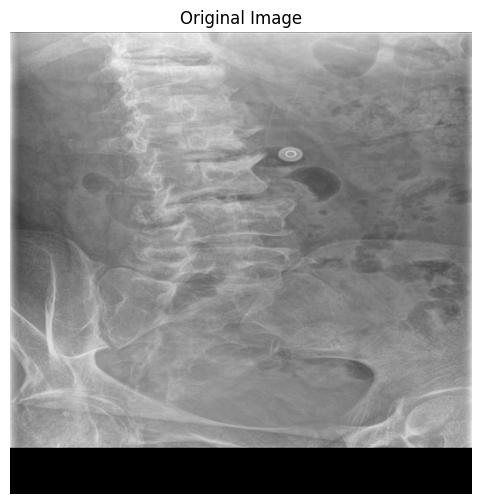

Original image shape: (512, 512)
Tensor shape after transform: torch.Size([3, 512, 512])
Final tensor shape with batch dimension: torch.Size([1, 3, 512, 512])
Tensor dtype: torch.float32
Tensor value range: [0.000, 0.984]


In [3]:
# Load an example image from val or test set.

idx = 5
IMAGE_FP = IMAGE_FPS[idx]
REPORT = REPORTS[idx]

# Load the PNG file
image_path = os.path.expanduser(IMAGE_FP) 
image = Image.open(image_path)

# Convert to RGB if it's not already (in case it's grayscale or RGBA)
if image.mode != 'RGB':
    image = image.convert('RGB')


# Visualize the image before converting to tensor
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.title("Original Image")
plt.show()

# Define transform to convert PIL image to tensor with batch dimension.
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL image to tensor and scales to [0,1]
])
tensor = transform(image)
tensor_batched = tensor.unsqueeze(0)

print(f"Original image shape: {image.size}")
print(f"Tensor shape after transform: {tensor.shape}")
print(f"Final tensor shape with batch dimension: {tensor_batched.shape}")
print(f"Tensor dtype: {tensor_batched.dtype}")
print(f"Tensor value range: [{tensor_batched.min():.3f}, {tensor_batched.max():.3f}]")

# The tensor is now ready for input to your classifier
tensor_for_classifier = tensor_batched.to(device='cuda').to(torch.bfloat16)

In [4]:
output = model(tensor_for_classifier)
print("output.keys():", output.keys())
score = torch.nn.Sigmoid()(output['output']).detach().float().cpu().numpy()[0][0]
print(f"Score: {score}")

output.keys(): dict_keys(['output', 'embeddings', 'last_hidden_state', 'attention_weights'])
Score: 0.9765625


shape of attn weights: (1296,)
max attn weight: 0.2578125
min attn weight: 2.0944488e-33
mean attn weight: 0.0007708868
std attn weight: 0.011433309
median attn weight: 6.0368377e-16
25th percentile attn weight: 8.787967e-20
75th percentile attn weight: 2.160494e-13


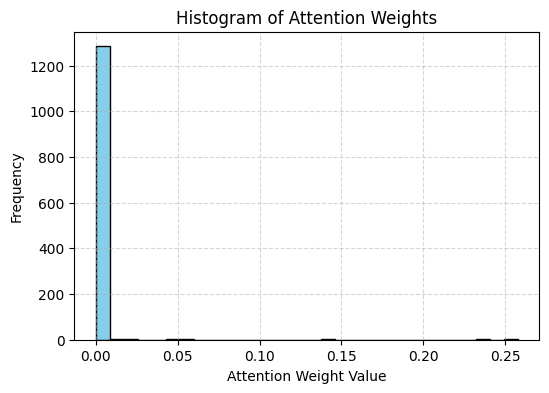

In [5]:
attn_weights = output['attention_weights'].detach().to(torch.float32).cpu().numpy()
attn_weights = attn_weights[0][0]
print("shape of attn weights:", attn_weights.shape)
print("max attn weight:", attn_weights.max())
print("min attn weight:", attn_weights.min())
print("mean attn weight:", attn_weights.mean())
print("std attn weight:", attn_weights.std())
print("median attn weight:", np.median(attn_weights))
print("25th percentile attn weight:", np.percentile(attn_weights, 25))
print("75th percentile attn weight:", np.percentile(attn_weights, 75))

plt.figure(figsize=(6, 4))
plt.hist(attn_weights, bins=30, range=(0, attn_weights.max()), color='skyblue', edgecolor='black')
plt.title("Histogram of Attention Weights")
plt.xlabel("Attention Weight Value")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

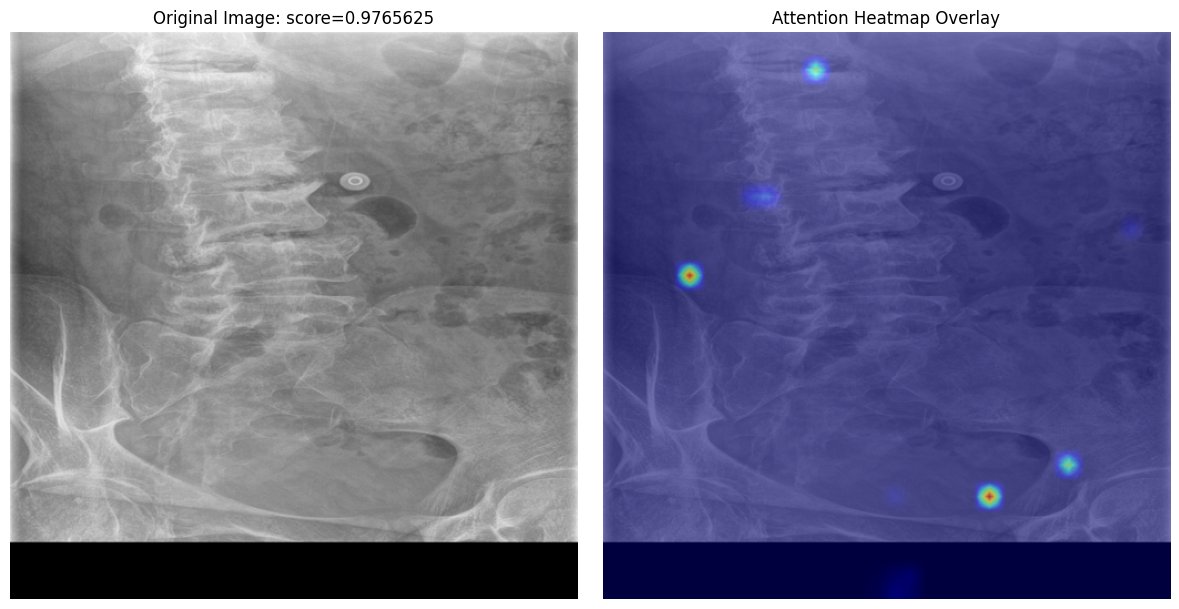

CLINICAL DATA:
Lumbosacral back pain. Fall yesterday. Right flank and right back pain radiating down right leg. Patient reports pain prior to fall.
EXAM:
LUMBAR SPINE COMPLETE 4+ VIEW
COMPARISON:
None found.
FINDINGS:
Diminutive ribs at T12. Moderately severe T12 compression fracture with approximately [X]% loss of height anteriorly. Mild compression fracture at T11 and possibly T10. Chronic loss of height of L1 vertebral body. Modic endplate changes with endplate sclerosis at L1-L2 and L2-L3. Diffuse disc disease with disc space narrowing, endplate spurring, and vacuum phenomenon, most prominent at L1-L2. Multilevel facet hypertrophy.
IMPRESSION:
1. Moderately severe T12 compression fracture with approximately [X]% loss of height anteriorly.
2. Mild T11 and possibly T10 compression fractures.
3. Chronic mild loss of height of L1.
4. Multilevel degenerative disc disease and facet hypertrophy, most prominent at L1-L2 and L2-L3.


In [6]:
num_patches = int(output['attention_weights'].shape[-1])
attention_weights = output['attention_weights'].detach()[:, :, :].reshape(1, int(np.sqrt(num_patches)), int(np.sqrt(num_patches)))

# Get original image size (height, width)
orig_h, orig_w = image.size[1], image.size[0]

# Upsample attention weights to original image size
# attention_weights shape: (1, H_patch, W_patch)
attn_map = attention_weights
attn_map_upsampled = F.interpolate(attn_map.unsqueeze(1), size=(orig_h, orig_w), mode='bilinear', align_corners=False)
attn_map_upsampled = attn_map_upsampled.squeeze().to(torch.float32).cpu().numpy()

# Normalize attention map for visualization
attn_map_norm = (attn_map_upsampled - attn_map_upsampled.min()) / (attn_map_upsampled.max() - attn_map_upsampled.min() + 1e-8)

# Plot side-by-side: original image and attention heatmap overlay
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title(f"Original Image: score={score}")

# Overlay image
axs[1].imshow(image)
axs[1].imshow(attn_map_norm, cmap='jet', alpha=0.5)
axs[1].axis('off')
axs[1].set_title("Attention Heatmap Overlay")

plt.tight_layout()
plt.show()
print(REPORT)